importing required packages

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split,KFold
from torchvision import models, transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import os
import copy
from skimage.draw import disk
from skimage.segmentation import flood_fill
from skimage.segmentation import find_boundaries
from skimage.draw import polygon
from scipy.ndimage import binary_dilation
import random
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

mounting on google drive and opening the .mat files

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:

# Open the .mat file using h5py
# mat_file = h5py.File(r'C:\Users\hites\OneDrive\Desktop\machine learning\Brain Tumor Datasets-2\Brain Tumor Datasets\Dataset 3\Dataset 3\brainTumorDataPublic_1-766\1.mat', 'r')

# List all available dataset names in the file
# print(list(mat_file.keys()))

# Close the file
# mat_file.close()

# Define the directory containing the .mat files
directory = [r'/content/drive/MyDrive/breatcancer/brainTumorDataPublic_1-766'
            ,r'/content/drive/MyDrive/breatcancer/brainTumorDataPublic_767-1532'
            ,r'/content/drive/MyDrive/breatcancer/brainTumorDataPublic_1533-2298'
            ,r'/content/drive/MyDrive/breatcancer/brainTumorDataPublic_2299-3064']

# Create a list to store the loaded data from all files
all_data = []
segmented_tumor_data=[]
# Iterate through the .mat files in the directory
for each_dir in directory:
    for filename in os.listdir(each_dir):
        if filename.endswith('.mat'):
            # Construct the full file path
            file_path = os.path.join(each_dir, filename)

            # Load the .mat file using h5py
            with h5py.File(file_path, 'r') as file:
                # Access the data fields within the HDF5 dataset
                label = file['cjdata']['label'][0, 0]
                patient_id = file['cjdata']['PID'][:]
                image_data = file['cjdata']['image'][:]
                tumor_border = file['cjdata']['tumorBorder'][:]
                tumor_mask = file['cjdata']['tumorMask'][:]
                segmented_tumor_data.append(np.where(tumor_mask == 1,image_data, 0))

                # Append the loaded data to the list
                all_data.append({
                    'label': label,
                    'patient_id': patient_id,
                    'image_data': image_data,
                    'tumor_border': tumor_border,
                    'tumor_mask': tumor_mask
                })
print(f'number of mri images: {len(all_data)}')

number of mri images: 3064


cheking unique patient id's

IMAGE SEGMENTATION:
segmenting the tumor region using the tumor border and expanding this region
by a factor of 25% .As the tumor surrounding tissues also provide valuable tumor information

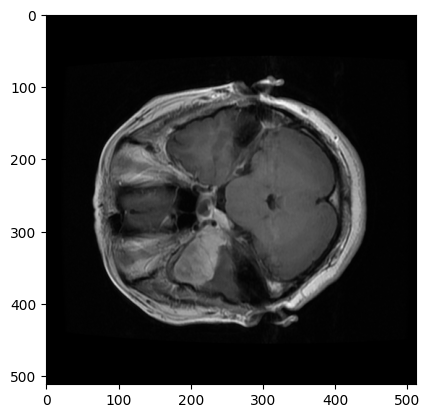

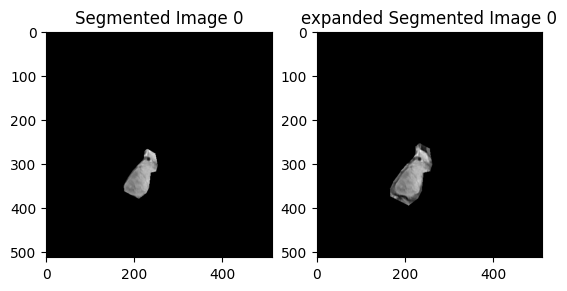

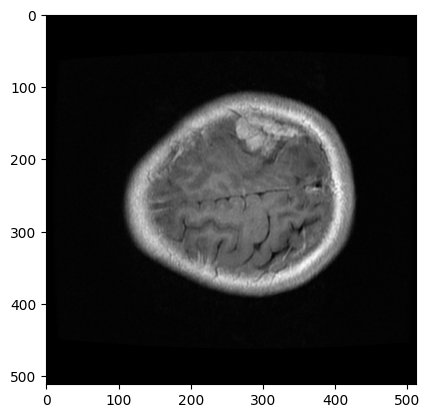

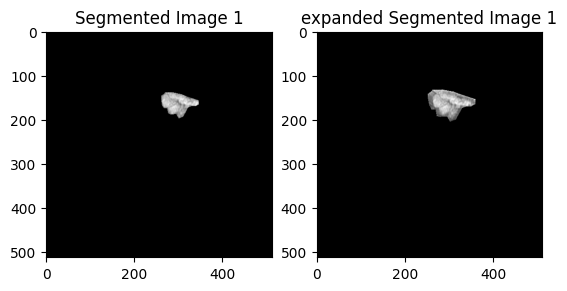

In [4]:
expanding_factor = 0.25
expanded_segmented_tumor_data = []

for data in all_data:
    image_data = data['image_data']
    tumor_border = data['tumor_border'][0]

    test = np.ones_like(image_data)
    expanded_segmented_region = np.zeros_like(image_data)

    # Extracting x and y coordinates from tumor_border
    x_mean = np.mean([int(tumor_border[i]) for i in range(0, len(tumor_border), 2)])
    y_mean = np.mean([int(tumor_border[i + 1]) for i in range(0, len(tumor_border), 2)])
    expanded_x_coords = [int((int(tumor_border[i]) - x_mean)*expanding_factor+int(tumor_border[i]))for i in range(0, len(tumor_border), 2)]
    expanded_y_coords = [int((int(tumor_border[i+1]) - y_mean)*expanding_factor+int(tumor_border[i+1])) for i in range(0, len(tumor_border), 2)]
    # Creating a filled polygon based on the tumor border
    rr, cc = polygon(expanded_y_coords, expanded_x_coords)
    # Ensuring the indices are within image bounds
    rr = np.clip(rr, 0, image_data.shape[0] - 1)
    cc = np.clip(cc, 0, image_data.shape[1] - 1)
    # Setting the pixels within the polygon to the corresponding values from the original image
    expanded_segmented_region[rr, cc] = test[rr, cc]
    expanded_segmented_region = np.rot90(np.fliplr(expanded_segmented_region))

    expanded_segmented_tumor_data.append(np.where(expanded_segmented_region == 1,image_data, 0))

for i in range(2):
    image_data = all_data[i]['image_data']
    plt.imshow(image_data,cmap = 'gray')
    plt.show()
    expanded_segmented_image = expanded_segmented_tumor_data[i]
    plt.subplot(1,2,1)
    plt.imshow(segmented_tumor_data[i], cmap='gray')
    plt.title(f"Segmented Image {i}")
    plt.subplot(1,2,2)
    plt.imshow(expanded_segmented_image, cmap='gray')
    plt.title(f"expanded Segmented Image {i}")
    plt.show()


label mapping

In [5]:

labels = np.array([item['label'] for item in all_data])
label_mapping = {1: 0, 2: 1, 3: 2}
labels = np.array([label_mapping[label] for label in labels])
print(labels.shape)

tumor_data = ([item['image_data'] for item in all_data])

tumor_border = ([item['tumor_border'] for item in all_data])

tumor_mask = ([item['tumor_mask'] for item in all_data])

# print(len(tumor_data))
# print(len(tumor_border))
# print(len(expanded_segmented_tumor_data))

(3064,)


data preprocessing segmented tumor data

1.  converting to tensors
2.  reshaping to 256x256
3.  train test split

In [6]:
data_transforms = transforms.Compose([transforms.ToTensor(),lambda x: x.to(torch.float32)])
expanded_segmented_tumor_data = [data_transforms(image) for image in expanded_segmented_tumor_data]
expanded_segmented_tumor_data = [transforms.Resize((256,256))(image) for image in expanded_segmented_tumor_data]

mean = torch.zeros(1)
std = torch.zeros(1)

for image in expanded_segmented_tumor_data:
    mean += image.mean()
    std += image.std()

mean /= len(expanded_segmented_tumor_data)
std /= len(expanded_segmented_tumor_data)

# Squeeze to remove singleton dimensions
mean = mean.squeeze()
std = std.squeeze()

expanded_segmented_tumor_data = [transforms.Normalize(mean, std)(image) for image in expanded_segmented_tumor_data]

data_train,data_test,label_train,label_test = train_test_split(expanded_segmented_tumor_data,labels,test_size=0.1)
train_data = list(zip(data_train, label_train))
test_data = list(zip(data_test, label_test))

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [7]:
print(len(data_train),len(label_train))
print(len(data_test),len(label_test))
print(data_train[0].shape)

batch_size = 16

2757 2757
307 307
torch.Size([1, 256, 256])


In [8]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         shuffle=False)

vizualizing a batch of train_loader data

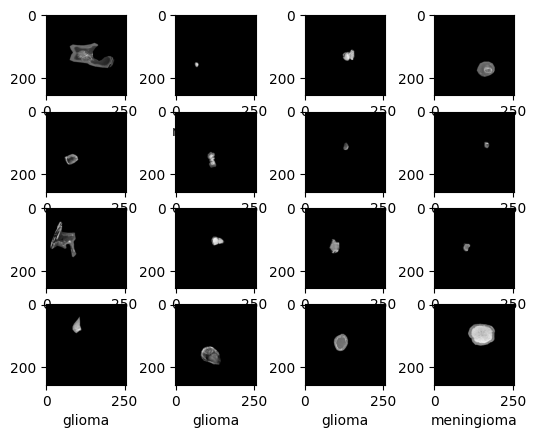

In [9]:

images,labels = next(iter(train_loader))
i=0
#1 for meningioma, 2 for glioma, 3 for pituitary tumor
classes = {0:'meningioma',1:'glioma',2:'pituitary'}
for i in range(len(images)):
    image = images[i]
    label = labels[i].item()
    i+=1
    plt.subplot(4,4,i)
    plt.imshow(image[0],cmap='gray')
    plt.xlabel(f'{classes[label]}')
plt.show()

model training

In [10]:
data_loader = {'train': train_loader, 'val': test_loader}
dataset_sizes = {'train':2757,'val':307}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
              model.train()  # Set model to training mode
            else:
              model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in data_loader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(torch.long)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

pretrained resnet18 model

In [13]:
#### ConvNet as fixed feature extractor ####
# Here, we need to freeze all the network except the final layer.
# We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward()
model_conv = torchvision.models.resnet18(pretrained=True)
model_conv.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 3)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=20)

Epoch 1/20
----------
train Loss: 0.7848 Acc: 0.6583
val Loss: 0.5853 Acc: 0.7720
Epoch 2/20
----------
train Loss: 0.6345 Acc: 0.7483
val Loss: 0.5391 Acc: 0.8046
Epoch 3/20
----------
train Loss: 0.5814 Acc: 0.7726
val Loss: 0.5491 Acc: 0.8013
Epoch 4/20
----------
train Loss: 0.5662 Acc: 0.7773
val Loss: 0.4934 Acc: 0.8176
Epoch 5/20
----------
train Loss: 0.5765 Acc: 0.7635
val Loss: 0.4865 Acc: 0.8371
Epoch 6/20
----------
train Loss: 0.5350 Acc: 0.7889
val Loss: 0.4713 Acc: 0.8371
Epoch 7/20
----------
train Loss: 0.5132 Acc: 0.8012
val Loss: 0.4789 Acc: 0.8241
Epoch 8/20
----------
train Loss: 0.4896 Acc: 0.8089
val Loss: 0.4455 Acc: 0.8274
Epoch 9/20
----------
train Loss: 0.4964 Acc: 0.8034
val Loss: 0.4462 Acc: 0.8306
Epoch 10/20
----------
train Loss: 0.4890 Acc: 0.8067
val Loss: 0.4536 Acc: 0.8274
Epoch 11/20
----------
train Loss: 0.4804 Acc: 0.8099
val Loss: 0.4459 Acc: 0.8306
Epoch 12/20
----------
train Loss: 0.4960 Acc: 0.8030
val Loss: 0.4504 Acc: 0.8371
Epoch 13/20
-

training the pretrained resnet18 model with optimizing the convolutional layers aswell

In [14]:
#### ConvNet as fixed feature extractor ####
# Here, we need to freeze all the network except the final layer.
# We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward()
model_conv = torchvision.models.resnet18(pretrained=True)
model_conv.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 3)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=20)

Epoch 1/20
----------
train Loss: 0.7941 Acc: 0.6540
val Loss: 0.6318 Acc: 0.7459
Epoch 2/20
----------
train Loss: 0.6438 Acc: 0.7446
val Loss: 0.5710 Acc: 0.7818
Epoch 3/20
----------
train Loss: 0.5892 Acc: 0.7592
val Loss: 0.5290 Acc: 0.8111
Epoch 4/20
----------
train Loss: 0.5898 Acc: 0.7624
val Loss: 0.5129 Acc: 0.8046
Epoch 5/20
----------
train Loss: 0.5509 Acc: 0.7777
val Loss: 0.5575 Acc: 0.7785
Epoch 6/20
----------
train Loss: 0.5919 Acc: 0.7635
val Loss: 0.5152 Acc: 0.8111
Epoch 7/20
----------
train Loss: 0.5212 Acc: 0.7914
val Loss: 0.5020 Acc: 0.8078
Epoch 8/20
----------
train Loss: 0.4988 Acc: 0.8038
val Loss: 0.4857 Acc: 0.8013
Epoch 9/20
----------
train Loss: 0.5069 Acc: 0.7998
val Loss: 0.4809 Acc: 0.8176
Epoch 10/20
----------
train Loss: 0.5036 Acc: 0.8099
val Loss: 0.4684 Acc: 0.8176
Epoch 11/20
----------
train Loss: 0.4935 Acc: 0.8063
val Loss: 0.4810 Acc: 0.8241
Epoch 12/20
----------
train Loss: 0.4957 Acc: 0.8107
val Loss: 0.4767 Acc: 0.8013
Epoch 13/20
-

data preprocessing complete mri images

In [6]:


data_transforms = transforms.Compose([transforms.ToTensor(),
                                      lambda x: x.to(torch.float32)])
tumor_data = [data_transforms(image) for image in tumor_data]
tumor_data = [transforms.Resize((256,256))(image) for image in tumor_data]

mean = torch.zeros(1)
std = torch.zeros(1)

for image in tumor_data:
    mean += image.mean()
    std += image.std()

mean /= len(tumor_data)
std /= len(tumor_data)

# Squeeze to remove singleton dimensions
mean = mean.squeeze()
std = std.squeeze()

tumor_data = [transforms.Normalize(mean, std)(image) for image in tumor_data]
data_train,data_test,label_train,label_test = train_test_split(tumor_data,labels,test_size=0.1)
train_data = list(zip(data_train, label_train))
test_data = list(zip(data_test, label_test))

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [7]:
print(len(data_train),len(label_train))
print(len(data_test),len(label_test))
print(data_train[0].shape)

batch_size = 16

2757 2757
307 307
torch.Size([1, 256, 256])


In [8]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         shuffle=False)


visualizing a batch of train_loder data

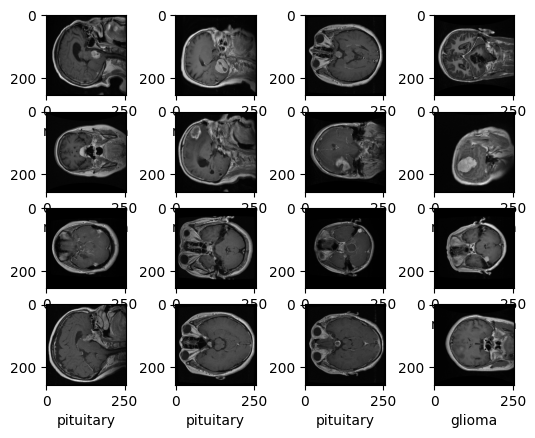

In [9]:
images,labels = next(iter(train_loader))
i=0
#1 for meningioma, 2 for glioma, 3 for pituitary tumor
classes = {0:'meningioma',1:'glioma',2:'pituitary'}
for i in range(len(images)):
    image = images[i]
    label = labels[i].item()
    i+=1
    plt.subplot(4,4,i)
    plt.imshow(image[0],cmap='gray')
    plt.xlabel(f'{classes[label]}')
plt.show()

In [13]:
data_loader = {'train': train_loader, 'val': test_loader}
dataset_sizes = {'train':2757,'val':307}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

training the pretrained resnet18 on complete mri images

In [14]:
#### ConvNet as fixed feature extractor ####
# Here, we need to freeze all the network except the final layer.
# We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward()
model_conv = torchvision.models.resnet18(pretrained=True)
model_conv.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 3)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=20)

Epoch 1/20
----------
train Loss: 0.7164 Acc: 0.6895
val Loss: 0.4909 Acc: 0.7915
Epoch 2/20
----------
train Loss: 0.4967 Acc: 0.7965
val Loss: 0.4126 Acc: 0.8306
Epoch 3/20
----------
train Loss: 0.4667 Acc: 0.8078
val Loss: 0.4061 Acc: 0.8078
Epoch 4/20
----------
train Loss: 0.4539 Acc: 0.8114
val Loss: 0.3806 Acc: 0.8469
Epoch 5/20
----------
train Loss: 0.4038 Acc: 0.8306
val Loss: 0.3770 Acc: 0.8469
Epoch 6/20
----------
train Loss: 0.4315 Acc: 0.8292
val Loss: 0.3880 Acc: 0.8111
Epoch 7/20
----------
train Loss: 0.4032 Acc: 0.8335
val Loss: 0.3530 Acc: 0.8697
Epoch 8/20
----------
train Loss: 0.3542 Acc: 0.8531
val Loss: 0.3327 Acc: 0.8567
Epoch 9/20
----------
train Loss: 0.3682 Acc: 0.8556
val Loss: 0.3544 Acc: 0.8795
Epoch 10/20
----------
train Loss: 0.3593 Acc: 0.8643
val Loss: 0.3503 Acc: 0.8664
Epoch 11/20
----------
train Loss: 0.3592 Acc: 0.8527
val Loss: 0.3380 Acc: 0.8664
Epoch 12/20
----------
train Loss: 0.3623 Acc: 0.8538
val Loss: 0.3514 Acc: 0.8599
Epoch 13/20
-

training model with early stopping : the training stop's when the validation accuracy of the model stops to get better for 7 continous epochs

In [17]:
def train_model_with_early_stopping(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    early_stop_counter = 0
    early_stop_threshold = 7

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in data_loader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(torch.long)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'val':
              if epoch_acc > best_acc:
                  best_acc = epoch_acc
                  best_model_wts = copy.deepcopy(model.state_dict())
                  early_stop_counter = 0
              else:
                  early_stop_counter += 1
              print(epoch_acc)
              print(best_acc)
              print(early_stop_counter)

        if early_stop_counter >= early_stop_threshold:
            print("Early stopping at epoch", epoch+1)
            break

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

custom cnn architecture from MilicaM.Badža1,2,* andMarkoCˇ.Barjaktarovic ́2 article on
Classification of Brain Tumors from MRI Images Using a Convolutional Neural Network

In [16]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()

        # Layer 1
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=2, padding=2)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)

        # Layer 2
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Layer 3
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.5)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Layer 4
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()
        self.dropout4 = nn.Dropout(0.5)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully Connected Layers
        self.fc1 = nn.Linear(2048, 1024)
        self.relu5 = nn.ReLU()
        self.fc2 = nn.Linear(1024, 3)  # Output classes: meningioma, glioma, pituitary tumor
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Forward pass

        # Layer 1
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.maxpool1(x)

        # Layer 2
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.maxpool2(x)

        # Layer 3
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.dropout3(x)
        x = self.maxpool3(x)

        # Layer 4
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.dropout4(x)
        x = self.maxpool4(x)

        # Flatten
        x = x.view(x.size(0), -1)
        # Fully Connected Layers
        x = self.fc1(x)
        x = self.relu5(x)
        x = self.fc2(x)
        x = self.softmax(x)

        return x

initializing xavier (glorot) weights

> xavier glorot is a type of weights initialization proccess where it tries to initialize weight for improved convergence and performance n training .
It's goal is to initialize initial weights which can avoid vanishing and exploding gradient problem .
The Xavier initialization is applied to weights with the following formula:

Var
(
W
)
=
1/
fan_in
+
fan_out



where:

Var(W) is the variance of the weights.
fan_in is the number of input units in the weight tensor.
fan_out is the number of output units in the weight tensor.


optimizer : Adam starting learning rate of 0.0004 weight decay of 0.004 and decaying lr by a factor of 0.1 every 7 epochs

In [19]:
def initialize_weights(layer):
    if isinstance(layer, nn.Conv2d):
        nn.init.xavier_uniform_(layer.weight)

# Instantiate the model
model_conv = CustomCNN()
model_conv.apply(initialize_weights)  # Applying Xavier (Glorot) weight initialization

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.Adam(model_conv.parameters(), lr=0.0004, weight_decay=0.004)  # Added weight decay for regularization

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


model_conv = train_model_with_early_stopping(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=50)

Epoch 1/50
----------
train Loss: 0.9642 Acc: 0.5822
val Loss: 0.9685 Acc: 0.6156
tensor(0.6156, device='cuda:0', dtype=torch.float64)
tensor(0.6156, device='cuda:0', dtype=torch.float64)
0
Epoch 2/50
----------
train Loss: 0.9412 Acc: 0.6039
val Loss: 0.9747 Acc: 0.6091
tensor(0.6091, device='cuda:0', dtype=torch.float64)
tensor(0.6156, device='cuda:0', dtype=torch.float64)
1
Epoch 3/50
----------
train Loss: 0.8862 Acc: 0.6435
val Loss: 1.0040 Acc: 0.6515
tensor(0.6515, device='cuda:0', dtype=torch.float64)
tensor(0.6515, device='cuda:0', dtype=torch.float64)
0
Epoch 4/50
----------
train Loss: 0.8351 Acc: 0.7066
val Loss: 0.9721 Acc: 0.6840
tensor(0.6840, device='cuda:0', dtype=torch.float64)
tensor(0.6840, device='cuda:0', dtype=torch.float64)
0
Epoch 5/50
----------
train Loss: 0.8125 Acc: 0.7262
val Loss: 0.9202 Acc: 0.7296
tensor(0.7296, device='cuda:0', dtype=torch.float64)
tensor(0.7296, device='cuda:0', dtype=torch.float64)
0
Epoch 6/50
----------
train Loss: 0.7861 Acc: 0.75

10 fold-cross-validation

In [56]:
torch.manual_seed(42)

# Defining the number of folds
num_folds = 10


accuracy_list = []
precision_list = []
recall_list = []
f1_score_list = []


conf_matrix = np.zeros((3, 3))



def initialize_weights(model):
    for layer in model.modules():
        if isinstance(layer, nn.Conv2d):
            nn.init.xavier_uniform_(layer.weight)



kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

for fold, (train_indices, val_indices) in enumerate(kf.split(range(len(data_loader['train'])))):
    print(f"Fold {fold + 1}/{num_folds}")

    # Create new instances of the model for each fold
    model_conv = CustomCNN()
    model_conv.apply(initialize_weights)
    model_conv = model_conv.to(device)

    optimizer_conv = optim.Adam(model_conv.parameters(), lr=0.0004, weight_decay=0.004)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


    train_data_fold = [data_loader['train'].dataset[i] for i in train_indices]
    val_data_fold = [data_loader['train'].dataset[i] for i in val_indices]

    train_loader_fold = torch.utils.data.DataLoader(train_data_fold, batch_size=batch_size, shuffle=True)
    val_loader_fold = torch.utils.data.DataLoader(val_data_fold, batch_size=batch_size, shuffle=False)


    model_conv = train_model_with_early_stopping(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=50)

    model_conv.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader_fold:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model_conv(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculating metrics for the current fold
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    # Updating the confusion matrix
    conf_matrix_fold = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2])
    conf_matrix += conf_matrix_fold

    # Printing metrics for the current fold
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix_fold)

    # Appending metrics to lists
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_score_list.append(f1)

# Calculating and printing average metrics over all folds
average_accuracy = np.mean(accuracy_list)
average_precision = np.mean(precision_list)
average_recall = np.mean(recall_list)
average_f1_score = np.mean(f1_score_list)

print("\nAverage Metrics Over All Folds:")
print(f"Average Accuracy: {average_accuracy:.4f}")
print(f"Average Precision: {average_precision:.4f}")
print(f"Average Recall: {average_recall:.4f}")
print(f"Average F1 Score: {average_f1_score:.4f}")


Fold 1/10
Epoch 1/50
----------
train Loss: 0.9358 Acc: 0.6123
val Loss: 0.9414 Acc: 0.6580
tensor(0.6580, device='cuda:0', dtype=torch.float64)
tensor(0.6580, device='cuda:0', dtype=torch.float64)
0
Epoch 2/50
----------
train Loss: 0.8683 Acc: 0.6765
val Loss: 0.9710 Acc: 0.5537
tensor(0.5537, device='cuda:0', dtype=torch.float64)
tensor(0.6580, device='cuda:0', dtype=torch.float64)
1
Epoch 3/50
----------
train Loss: 0.8415 Acc: 0.6942
val Loss: 0.9575 Acc: 0.6808
tensor(0.6808, device='cuda:0', dtype=torch.float64)
tensor(0.6808, device='cuda:0', dtype=torch.float64)
0
Epoch 4/50
----------
train Loss: 0.8086 Acc: 0.7323
val Loss: 0.9303 Acc: 0.7134
tensor(0.7134, device='cuda:0', dtype=torch.float64)
tensor(0.7134, device='cuda:0', dtype=torch.float64)
0
Epoch 5/50
----------
train Loss: 0.7948 Acc: 0.7443
val Loss: 0.8844 Acc: 0.7329
tensor(0.7329, device='cuda:0', dtype=torch.float64)
tensor(0.7329, device='cuda:0', dtype=torch.float64)
0
Epoch 6/50
----------
train Loss: 0.7780

plotting confusion matrix

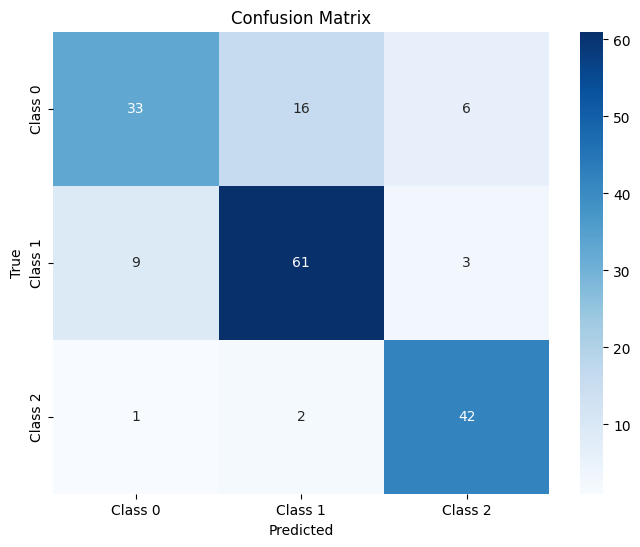

In [57]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()